In [1]:
import os
import shutil
import utilities as rocku
import matplotlib.pyplot as plt
import tomopy
import numpy as np
import pandas as pd
import pprint
import dxchange
import multiprocessing as mp
import timeit
from tqdm import tqdm

In [2]:
ncore = mp.cpu_count()
ncore

64

In [26]:
# need to change
ipts="32298"
# scan_type = 'ct_scans'
# scan_type = 'radiographs'
scan_type = 'dc'

# scan_type = 'alignment_calibration'

In [27]:
scan_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/" + scan_type
sorted(os.listdir(scan_loc))

['2024_07_31_Ni1_4', '2024_08_01_nGI_DC']

In [28]:
###################### need to change start
sample_name = "2024_08_01_nGI_DC"
scan_dir = os.path.join(scan_loc, sample_name)
gamma_diff = 20
###################### need to change end

# Preprocess scan files

In [29]:
fname_list = os.listdir(scan_dir)
# fname_list.pop(0)
fname_list.sort()
print(len(fname_list))
fname_list

10


['DC_0060_0013.tiff',
 'DC_0060_0014.tiff',
 'DC_0060_0015.tiff',
 'DC_0060_0016.tiff',
 'DC_0060_0017.tiff',
 'DC_0060_0018.tiff',
 'DC_0060_0019.tiff',
 'DC_0060_0020.tiff',
 'DC_0060_0021.tiff',
 'DC_0060_0022.tiff']

In [30]:
to_rmv = [
#     '20230919_dry_spun_fibers_0300_0013.tiff',
#  '20230919_dry_spun_fibers_0300_0014.tiff',
#  '20230919_dry_spun_fibers_0300_0015.tiff',
#  '20230919_dry_spun_fibers_rejoint_0300_0021.tiff',
#  '20230919_dry_spun_fibers_rejoint_0300_0022.tiff',
#  '20230919_dry_spun_fibers_rejoint_0300_0023.tiff',
#  '20230919_wet_spun_fibers_0300_0006.tiff',
#  '20230919_wet_spun_fibers_0300_0007.tiff',
#  '20230919_wet_spun_fibers_0300_0008.tiff',
]
fname_list = rocku.remove_fnames(fname_list, to_rmv)

10
10


In [31]:
######### Scan
scan_raw = rocku.read_tiff_stack(scan_dir, fname_list)

10it [00:08,  1.14it/s]


Text(0.5, 1.0, 'Scan (np.min)')

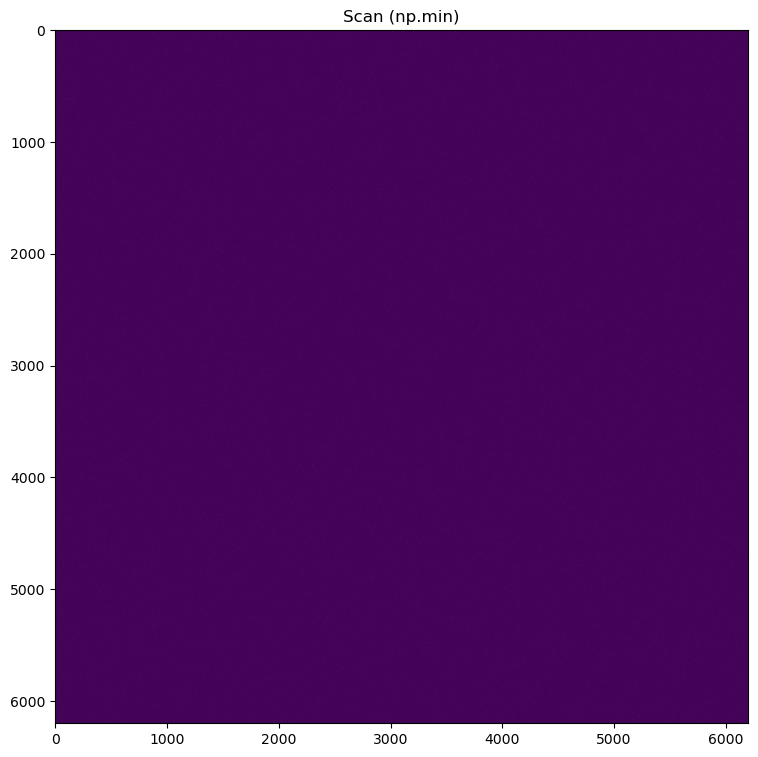

In [32]:
vmax = tomopy.misc.corr.remove_outlier(scan_raw[0], gamma_diff, ncore=ncore).astype(np.ushort).max()
##################
scan_min = np.min(scan_raw, axis=0)
f, ax = plt.subplots(1, 1, figsize=(20, 9))
ax.imshow(scan_min, vmax=vmax)
ax.set_title('Scan (np.min)')

# Crop ROI

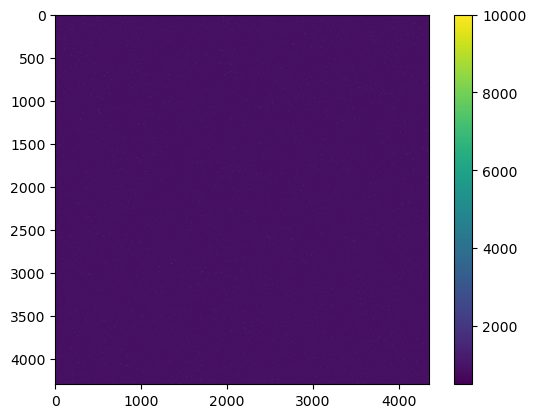

In [33]:
###################### need to change start
# crop = False
crop = True
crop_left = 950#950
crop_right = 5300#3850
crop_top = 1000#1400
crop_bottom = 5300#6200
###################### need to change end
scan_crop = rocku.crop(scan_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
scan_crop_min = rocku.crop(scan_min, crop_left, crop_right, crop_top, crop_bottom, crop)
plt.imshow(scan_crop_min, vmax=10000)
plt.colorbar()
plt.show()

# Removal outliers

In [34]:
t0 = timeit.default_timer()
scan_crop = tomopy.misc.corr.remove_outlier(scan_crop, gamma_diff, ncore=ncore).astype(np.ushort)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Time: 2.0764424493536353 s


In [35]:
# pixel_bin_size = 1
pixel_bin_size = 2
func = np.sum
# dtype = np.float16
dtype = np.float32
# dtype = np.float64
#################################################
t0 = timeit.default_timer()
scan_crop_resized = rocku.bin_pix(scan_crop, pixel_bin_size=pixel_bin_size, func=func, dtype=dtype)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Time: 1.6483804313465953 s


# Save files

In [36]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/pixel_binned/" + sample_name# + '_Right'
fname_list_save = fname_list[:]
print('Saving to {} ...'.format(save_to))
for i, e_name in tqdm(enumerate(fname_list_save)):
#     e_name = rocku.remove_1st_str(e_name)
    fname = save_to + "/" + e_name
    dxchange.write_tiff(scan_crop_resized[i], fname=fname, overwrite=True)

Saving to /HFIR/CG1D/IPTS-32298/shared/processed_data/pixel_binned/2024_08_01_nGI_DC ...


10it [00:00, 21.30it/s]
